# Zeeman slower
This document provides all the information about how to design a Zeeman slower using a magnetic field.
Includes an optional interactive matplotlib widget that lets you vary key parameters with sliders.

## Brief theory introduction

The Zeeman slower is a device used to slow down a beam of atoms using the radiation pressure from a counter-propagating monochromatic laser beam, while compensating for the changing Doppler shift.
Therefore, the laser exerts a force on the atoms, slowing them down over a certain distance with a force, $F_{scatt} = \sigma_{abs} I/c = \hbar k R_{scatt}$, where $\sigma_{abs}$ is the absorption cross-section, $I$ is the laser intensity, $c$ is the speed of light, $\hbar$ is the reduced Planck constant, $k$ is the wavevector of the laser light, and $R_{scatt}$ is the scattering rate $$R_{scatt} = \frac{\Gamma}{2} \frac{\Omega^2/2}{\delta^2+\Omega^2/2+\Gamma^2/4}$$ where $\Gamma$ is the linewidth, $\Omega$ is the Rabi frequency, and $\delta (z) = \omega_L - \omega_0 +kv(z)$ is the detuning where $\omega$ is the laser frequency, $\omega_0$ is the atomic transition frequency, and $kv(z)$ is the Doppler shift.
We can also define the laser detuning at rest as $\delta_0 = \omega_L - \omega_0$ such that the detuning becomes $\delta (z) = \delta_0 +kv(z)$.

Defining the saturation parameter as $s = I/I_{sat} = 2 \Omega^2/\Gamma^2$, where $I_{sat}$ is the saturation intensity, we can rewrite the scattering force as:$$F_{scatt} = \hbar k \frac{\Gamma}{2} \frac{s}{1+s+4(\delta/\Gamma)^2}.$$

When the intensity tends to infinity ($s \gg 1$) and the detuning is zero ($\delta = 0$), the scattering rate reaches its maximum value of $R_{scatt,max} = \Gamma/2$, leading to a maximum deceleration of the atoms given by:
$$a_{max} = \frac{F_{scatt,max}}{m} = \frac{\hbar k}{m} \frac{\Gamma}{2} = \frac{v_r}{2\tau}$$
where $m$ is the mass of the atom, $v_r = \hbar k / m$ is the recoil velocity, and $\tau$ is the excited state lifetime.

### Species properties and constants
Here we define relevant properties (mass, wavelength and linewidth) of several common atomic species used for laser cooling.
Such that we can use their linewidth to study in first instance the range where the scattering rate is significant for different saturation parameters.
We also define some useful constants and import necessary libraries.

In [ ]:
%matplotlib inline

# Imports and setup
import math
import wave
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import ipywidgets as w
from IPython.display import display, clear_output

# Physical constants (SI units)
hh = 6.62607015e-34  # J*s (Planck's constant)
hbar = hh / (2.0 * math.pi)
mu_B = 9.274009994e-24  # J/T (Bohr magneton)
amu = 1.66053906660e-27  # kg (atomic mass unit)

# Species dropdown with mass, wavelength (m), gamma (rad/s), and saturation intensity (mW/cm^2)
species_data = {
    'Ca-40':   {'mass': 40.078,  'wavelength': 422.67276e-9, 'gamma': 2 * math.pi * 34.6e6, 'sat_intensity': 60.0},
    'Sr-88':   {'mass': 87.62,   'wavelength': 460.862e-9,    'gamma': 2 * math.pi * 32.0e6},
    'Rb-87':   {'mass': 86.909,  'wavelength': 780.241e-9,    'gamma': 2 * math.pi * 6.065e6},
    'Cs-133':  {'mass': 132.905, 'wavelength': 852.347e-9,    'gamma': 2 * math.pi * 5.234e6},
    'Na-23':   {'mass': 22.990,  'wavelength': 589.158e-9,    'gamma': 2 * math.pi * 9.79e6},
    'Yb-174':  {'mass': 173.045, 'wavelength': 398.911e-9,    'gamma': 2 * math.pi * 29.0e6},
}

# Dropdown = an interactive ipywidgets selection control that lets the user pick
# exactly one option from a list. Its current selection is available as `species.value`
# and is used in later cells to look up `species_data[species.value]` and refresh plots.
# Changing this widget will trigger observers (attached later in the notebook) to
# recompute figures and labels for the chosen atom.
species = w.Dropdown(
    description='Species',
    options=list(species_data.keys()),
    value='Ca-40'
)

# If the interactive widgets already exist, refresh them so display labels
# pick up any newly edited parameter values (e.g., gamma).
for refresh_func_name in ("refresh_simple", "refresh_advanced"):
    refresh_callable = globals().get(refresh_func_name)
    if callable(refresh_callable):
        try:
            refresh_callable()
        except Exception as exc:
            print(f"Warning: {refresh_func_name} failed to refresh ({exc})")

### Scattering rate

Here we define a function that calculates the scattering rate, $R_{scatt}$, as a function of detuning, $\delta$, and saturation parameter, $s$, to study its dependence around zero detuning within the range of Ca linewidth approximately (as an order of magnitude).
It shows that for a given detuning, increasing the saturation parameter increases the scattering rate until a limit of $\Gamma / 2$; the larger the detuning, the more $s$ it takes to reach the limit of the scattering rate.
For a given saturation parameter, the scattering rate peaks at zero detuning and it is symmetric for positive and negative detuning; the larger saturation parameter, the broader and peak closer to $\Gamma / 2$.

In [ ]:
# Visualize how the scattering rate depends on saturation parameter and detuning
def scattering_rate(s_param, delta, gamma):
    return 0.5 * gamma * (s_param / (1.0 + s_param + 4.0 * (delta / gamma) ** 2))
# Get current species parameters
current_species = species_data[species.value]
gamma_val = current_species["gamma"]
# Prepare data for plotting
s_values = np.logspace(-2, 3, 400)
detuning_values = np.linspace(-4 * gamma_val, 4 * gamma_val, 600)
# Sample values for plotting
detuning_samples = [0.0, 0.5 * gamma_val, 1.0 * gamma_val, 2.0 * gamma_val]
saturation_samples = [0.05, 0.2, 1.0, 5.0, 20.0, 100.0]

# Widgets for eta target and report label
target_eta_slider = w.FloatSlider(
    description="η target",
    value=0.75,
    min=0.4,
    max=0.95,
    step=0.01,
    readout_format=".2f",
    continuous_update=False,
)
eta_report_label = w.HTML(value="")

def render_scattering_plots(target_eta):
    rates_vs_s = {delta: scattering_rate(s_values, delta, gamma_val) for delta in detuning_samples}
    rates_vs_delta = {s: scattering_rate(s, detuning_values, gamma_val) for s in saturation_samples}

    fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(12, 4.5))
    # Left plot: eta vs s for different detunings
    thresholds = []
    # Calculate saturation parameter thresholds for target eta at each detuning
    threshold_map = {}
    for delta, rates in rates_vs_s.items():
        eta_norm = rates / (gamma_val / 2)
        label = f"$\\delta$ = 2$\\pi$ {delta / (2 * math.pi * 1e6):.1f} MHz"
        ax_left.plot(s_values, eta_norm, label=label)
        mask = eta_norm >= target_eta
        if np.any(mask):
            idx = np.argmax(mask)
            if idx == 0:
                s_thresh = s_values[0]
            else:
                y0, y1 = eta_norm[idx - 1], eta_norm[idx]
                x0, x1 = s_values[idx - 1], s_values[idx]
                if y1 != y0:
                    s_thresh = np.interp(target_eta, [y0, y1], [x0, x1])
                else:
                    s_thresh = x1
            thresholds.append(s_thresh)
            threshold_map[delta] = s_thresh
            ax_left.scatter(s_thresh, target_eta, color="black", s=25, zorder=15)
        else:
            thresholds.append(np.nan)
            threshold_map[delta] = float("nan")

    # Plot target eta line and shaded region
    ax_left.axhline(target_eta, color="tab:red", linestyle="--", linewidth=1.2, label=f"$\\eta$ = {target_eta:.2f}")
    s_delta0 = threshold_map.get(0.0, float("nan"))
    # Plot vertical line and shaded region if threshold exists at delta = 0
    if math.isfinite(s_delta0):
        ax_left.axvline(s_delta0, color="tab:red", linestyle=":", linewidth=1.2)
        x_shade = np.logspace(np.log10(s_delta0), np.log10(s_values[-1]), 200)
        ax_left.fill_between(
            x_shade,
            target_eta,
            1.0,
            facecolor="tab:red",
            alpha=0.08,
            label="s meeting $\\eta$ ≥ target",
        )
    ax_left.set_xscale("log")
    ax_left.set_xlabel("Saturation parameter s")
    ax_left.set_ylabel("$\\eta$ = R_scatt / ($\\Gamma$/2)")
    ax_left.set_xlim(1e-2, 1e3)
    ax_left.set_ylim(0.0, 1.05)
    ax_left.legend(loc="lower right", fontsize=8)
    ax_left.grid(True, which="both", ls=":", alpha=0.5)

    # Right plot: eta vs detuning for different saturation parameters
    for s_val, rates in rates_vs_delta.items():
        eta_norm = rates / (gamma_val / 2)
        label = f"s = {s_val:.2f}" if s_val < 10 else f"s = {s_val:.0f}"
        ax_right.plot(detuning_values / (2 * math.pi * 1e6), eta_norm, label=label)

    ax_right.axhline(target_eta, color="tab:red", linestyle="--", linewidth=1.2)
    ax_right.axhspan(
        target_eta,
        1.0,
        facecolor="tab:red",
        alpha=0.08,
        label="$\\eta$ ≥ target",
    )
    ax_right.set_ylim(0.0, 1.05)
    ax_right.set_xlabel("Detuning $\\delta$ / (2$\\pi$·MHz)")
    ax_right.set_ylabel("$\\eta$ = R_scatt / ($\\Gamma$/2)")
    ax_right.legend(loc="upper right", fontsize=8)
    ax_right.grid(True, ls=":", alpha=0.5)

    plt.tight_layout()
    plt.show()

    # Update report label
    if math.isfinite(s_delta0):
        eta_report_label.value = (
            f"<b>s at δ = 0 meeting η = {target_eta:.2f}:</b> {s_delta0:.3f}"
        )
    else:
        eta_report_label.value = (
            f"<span style='color:red'><b>No s in plotted range reaches η = {target_eta:.2f} at δ = 0.</b></span>"
        )

plot_output = w.interactive_output(
    render_scattering_plots, {"target_eta": target_eta_slider}
)

display(w.VBox([target_eta_slider, eta_report_label]), plot_output)

Output()

*Note for the left-side plot*: What we are plotting here is the scattering rate normalized to the maximum scattering rate, i.e., $R_{scatt} / R_{scatt,max}$ which we can define as a quantity $\eta$.
This is of great relevance for the Zeeman slower as setting the eta we will work, sets the deceleration we will apply to the atoms.
Therefore, the **length of the Zeeman slower** and the magnetic field profile will depend on the chosen eta, and the **minimum $s$ such that the ZS will work**.

So, the shorter the Zeeman slower we want, the higher the eta we need, and therefore the higher the saturation parameter we will need to achieve that eta at the maximum detuning (i.e., at the maximum velocity we want to slow down).

The detuning that we apply on the laser from the ideal one at rest, $\delta_0$, will also affect the effective eta we will have at different points of the Zeeman slower, as the detuning will not be zero at all points.
Plus, this range might not be in the MHz range but in the GHz range for fast atomic beams, so the detuning effect will be more significant. 

### Velocity and magnetic field profiles

Here, we assume we are slowing down atoms at a constant deceleration using a counter-propagating laser beam at a rate $\frac{dv}{dt} = v \frac{dv}{dz} = - a$, and when we integrate over position we get the velocity profile as a function of position. Assuming constant deceleration, we can express the velocity as a function of position z along the slower as:
$$v(z) = \sqrt{v_0^2 - 2 a z}$$
where $v_0 = v(z=0)$ is the initial velocity of the atoms at the entrance of the slower, and $a$ is the constant deceleration which is usually expressed $a=\eta a_{max}$ where $\eta \in [0,1]$ is typically between 0.5 and 0.8 to give some margin compared to the maximum deceleration.
Thus, the stopping distance L required to slow atoms from initial velocity $v_0$ to final velocity $v_f = v(z=L)$ is given by:
$$L = \frac{v_0^2 - v_f^2}{2 \eta a_{max}}$$
such that we can express the velocity profile:
$$v(z) = \sqrt{v_0^2 - \left(v_0^2 - v_f^2\right)\frac{z}{L}}$$

Assuming $v_f=0$, $L = \frac{v_0^2}{2 \eta a_{max}}$ and $v(z) = v_0 \sqrt{1 - \frac{z}{L}}$.

When a beam of particles is slowed down using a counter-propagating laser beam, the particles experience a changing Doppler shift, $k v(z)$, as they decelerate.
To maintain resonance between the laser frequency and the atomic transition, a spatially varying magnetic field, $B(z)$, is applied along the length of the slower (or a chirped laser $\omega_L (z)$).

This magnetic field induces a Zeeman shift in the atomic energy levels, compensating for the changing Doppler shift.
$$\omega_0 \pm \frac{\mu B(z)}{\hbar} = \omega_L + k v(z)$$
where $\omega_0$ is the atomic transition frequency, $\omega_L$ is the laser frequency, $\mu_B$ is the Bohr magneton while $\mu = g_{eff} \mu_B$ where $g_{eff}$ is the effective Landé g-factor, and $v(z)$ is the velocity of the atoms at position z.

Hence, the ideal magnetic field profile for a Zeeman slower that maintains resonance throughout the slowing process until $v_f = 0$ via decreasing the field (+sign and $\sigma^+$ polarization) is given by:
$$B_+(z) = B_{bias,+} + B_0\sqrt{1-\frac{z}{L}}$$
where $B_0 = \frac{\hbar k v_0}{\mu} = \frac{h v_0}{\lambda \mu}$ is the maximum magnetic field strength at the entrance of the slower, and $B_{bias,+}$ is a constant offset magnetic field, such that $\mu B_{bias,+} = \hbar \delta_0$ where $\delta_0 = \omega_L - \omega_0$ is the detuning of the laser frequency from the atomic transition frequency.

Whereas the decreasing-field Zeeman slower (-sign and $\sigma^-$ polarization) is for a general final velocity $v_f$,
$$B_-(z) = B_{bias,-} + B_0\left(1-\sqrt{1-\frac{v_0^2 - v_f^2}{v_0^2}\frac{z}{L}}\right)$$
where $B_{bias,-}$ is a constant offset magnetic field, such that $\mu (B_{bias,-} + B_0)= - \hbar \delta_0$.

In case of need to look for more spectral lines, please refer to: https://physics.nist.gov/PhysRefData/ASD/lines_form.html

Or atoms information Safranova 
https://www1.udel.edu/atom

## Increasing-field Zeeman slower study

The following code aims to study the increasing-field Zeeman slower for a general final velocity $v_f$.
The key parameters that can be adjusted are the initial velocity $v_0$, final velocity $v_f$, and slowing efficiency $\eta$, which will mainly determine the length of the Zeeman slower, $L = \frac{v_0^2 - v_f^2}{2 \eta a_{max}}$, together with the atom species to be slowed, which has a certain mass $m$, linewidth $\gamma$, and wavelength $\lambda$ that set the $a_{max} = \frac{h}{m \lambda} \frac{\Gamma}{2}$; and the magnetic field profile, $B_-(z)$, which is also affected by the effective Landé g-factor $g_{eff}$ of the transition and the bias magnetic field, $B_{bias}$.

The distance from the oven to the Zeeman slower is fixed due to experimental constraints, which is 156 mm, the tube where the Zeeman slower is mounted is 300 mm, and the distance between the end of this tube and the deflectometer is 53 mm.

In [3]:
# Clean up previous UI instances to prevent stacked displays when this cell is re-run
for _widget_name in ("_advanced_ui", "_advanced_output"):
    # Widgets stick around across executions; closing avoids duplicated plots/controls.
    _existing_widget = globals().get(_widget_name)
    if _existing_widget is not None:
        try:
            _existing_widget.close()
        except Exception:
            pass

def plot_profile(z_plt, v_plt, B_plt, L_plt):
    """
    Plot Zeeman-slower magnetic field and velocity versus position.

    Parameters
    - z_plt (array-like): Positions along the slower [m]. Must be the same length as v_plt and B_plt.
    - v_plt (array-like): Velocity profile v(z) [m/s].
    - B_plt (array-like): Magnetic-field profile B(z) [T]. Converted to Gauss (×1e4) for display.
    - L_plt (float): Slower length [m]. Used for the plot title only.

    Behavior
    - Produces a matplotlib figure with two y-axes sharing z:
      left axis: B(z) in Gauss; right axis: v(z) in m/s.
    - Uses NaN-safe maxima to set y-limits and adds a small negative margin.
    - Applies grid and tight layout, then displays the figure. Returns None.

    Notes
    - NaN values are ignored for axis scaling.
    - If arrays are empty, minimal nonzero limits are used to avoid errors.
    - Inputs are not modified.
    """
    fig, ax1 = plt.subplots(figsize=(7, 4))
    ax1.set_xlabel("z (m)")
    ax1.set_ylabel("B (G)", color="tab:blue")
    ax1.plot(z_plt, B_plt * 1e4, color="tab:blue", lw=2, label="B(z) [G]")
    ax1.tick_params(axis="y", labelcolor="tab:blue")
    ax1.grid(True, ls="--", alpha=0.4)
    ax2 = ax1.twinx()
    ax2.set_ylabel("v (m/s)", color="tab:orange")
    ax2.plot(z_plt, v_plt, color="tab:orange", lw=2, label="v(z) [m/s]")
    ax2.tick_params(axis="y", labelcolor="tab:orange")
    max_B = np.nanmax(B_plt * 1e4) if np.size(B_plt) else 1.0
    max_v = np.nanmax(v_plt) if np.size(v_plt) else 1.0
    max_B = max(1e-8, max_B) * 1.05
    max_v = max(1e-8, max_v) * 1.05
    ax1.set_ylim(-0.05 * max_B, max_B)
    ax2.set_ylim(-0.05 * max_v, max_v)
    ax1.set_title(f"Zeeman slower profile (L = {L_plt*100:.2f} cm)")
    plt.tight_layout()
    plt.show()

def compute_B_z_forces(mass_amu=40.078, wavelength=422.67276e-9, gamma=2*math.pi*34.6e6, g_eff=1.0,
                    v0=500.0, vf=50.0, B_bias=250, eta=0.5, n_points=500):
    """
    Compute the 1D Zeeman-slower magnetic-field and velocity profiles for an
    increasing-field design assuming constant deceleration a = eta * a_max,
    where a_max = (ħ k γ / 2) / m.

    Parameters
    - mass_amu (float): Atomic mass in atomic mass units [amu].
    - wavelength (float): Transition wavelength [m].
    - gamma (float): Natural linewidth Γ, angular frequency [rad/s].
    - g_eff (float): Effective magnetic g-factor (dimensionless).
    - v0 (float): Entrance velocity (capture velocity) [m/s].
    - vf (float): Exit velocity (final velocity) [m/s].
    - B_bias (float): Entrance bias field in Gauss.
    - eta (float): Fraction of the maximum scattering force (0 < eta ≤ 1).
    - n_points (int): Number of samples along z inside the slower.

    Returns
    - z (ndarray): Positions along the slower [m], from 0 to L.
    - v (ndarray): Velocity profile v(z) [m/s].
    - B (ndarray): Magnetic-field profile B(z) [T].
    - L (float): Slower length [m].
    - diagnostics (dict): Additional scalars:
        * F_max [N]     : Maximum scattering force (s → ∞).
        * a_max [m/s^2] : Maximum deceleration = F_max / m.
        * a [m/s^2]     : Chosen deceleration = eta * a_max.
        * B_delta [T]   : Scale field = ħ k v0 / (μ_B g_eff).
        * delta_ideal   : Design detuning (angular) for z=0 resonance [rad/s].

    Notes
    - B_bias is provided in Gauss; the returned B(z) is in Tesla (multiply by 1e4 to get Gauss).
    - Raises ValueError if the computed deceleration is non-positive or if v0 ≤ vf.
    - Uses the standard increasing-field Zeeman-slower profile:
        v(z) = sqrt(v0^2 - (v0^2 - vf^2) * z / L)
        B(z) = B_bias_T + B_delta * (1 - sqrt(1 - ((v0^2 - vf^2)/v0^2) * (z / L)))
      with L = (v0^2 - vf^2) / (2 a) and B_delta = ħ k v0 / (μ_B g_eff).
    """
    mm = mass_amu * amu     # Convert mass from amu to kg
    kk = 2 * math.pi / wavelength   # Wave number k [1/m]
    F_max = hbar * kk * gamma / 2.0  # Max scattering force [N]
    a_max = F_max / mm      # Max deceleration [m/s^2]
    aa = eta * a_max        # Chosen deceleration [m/s^2]
    # Input validation
    if aa <= 0:
        raise ValueError("Computed deceleration <= 0; check s0 and eta")
    if v0 <= vf:
        raise ValueError("Initial velocity v0 must be > final velocity vf")
    # Ideal-length and magnetic profile for the increasing-field design.
    LL = (v0 * v0 - vf * vf) / (2.0 * aa)       # Slower length [m]
    B_delta = hbar * kk / (mu_B * g_eff) * v0     # Scale field [T]
    B_bias_T = B_bias * 1e-4                    # Gauss slider uses CGS units → Tesla
    zz = np.linspace(0.0, LL, n_points)          # Positions along the slower [m]
    vv = np.sqrt(v0**2 - (v0**2 - vf**2) * zz / LL)   # Velocity profile [m/s]
    # Magnetic field profile [T]
    BB = B_bias_T + B_delta * (1 - np.sqrt(1 - ((v0**2 - vf**2) / v0**2) * (zz / LL)))
    delta_ideal = - mu_B * g_eff * (B_bias_T + B_delta) / hbar    # Design detuning [rad/s]
    diagnostics = {
        "F_max": F_max,     # Maximum scattering force [N]
        "a_max": a_max,     # Maximum deceleration [m/s^2]
        "a": aa,            # Chosen deceleration [m/s^2]
        "B_delta": B_delta,  # Scale field [T]
        "delta_ideal": delta_ideal,  # Design detuning [rad/s]
    }
    return zz, vv, BB, LL, diagnostics

# Slider definitions (all use continuous_update=False to avoid overwhelming plots).
v0_adv = w.FloatSlider(description="v0 (m/s)", value=1000.0,
                       min=400.0, max=1200.0, step=5.0, continuous_update=False)
vf_adv = w.FloatSlider(description="vf (m/s)", value=50.0,
                       min=0.0, max=100.0, step=5.0, continuous_update=False)
eta_adv = w.FloatSlider(description="eta", value=0.75,
                        min=0.01, max=1.0, step=0.01, continuous_update=False)
B_bias_adv = w.FloatSlider(description="B_bias (G)", value=250.0,
                           min=1.0, max=500.0, step=1.0, continuous_update=False)
g_eff_adv = w.FloatSlider(description="g_eff", value=1.0,
                          min=0, max=2.0, step=0.01, continuous_update=False)
points_adv = w.IntSlider(description="points", value=600,
                         min=50, max=1000, step=50, continuous_update=False)
# Dynamic labels and output container.
wavelength_label_advanced = w.HTML()
gamma_label_advanced = w.HTML()
summary_label_advanced = w.HTML()
out_advanced = w.Output()
# Update wavelength and gamma labels based on selected species.
def update_info_advanced():
    d = species_data[species.value]
    wavelength_label_advanced.value = f"<b>&lambda;</b>: {d['wavelength']*1e9:.3f} nm"
    gamma_label_advanced.value = f"<b>&Gamma;/2&pi;</b>: {d['gamma']/(2*math.pi)/1e6:.3f} MHz"
# Refresh function to recompute and plot the profiles.
def refresh_advanced(change=None):
    d = species_data[species.value]
    update_info_advanced()
    try:
        zz, vv, BB, LL, diag = compute_B_z_forces(
            mass_amu=d['mass'],
            wavelength=d['wavelength'],
            gamma=d['gamma'],  # Use angular frequency
            v0=v0_adv.value,
            vf=vf_adv.value,
            eta=eta_adv.value,
            B_bias=B_bias_adv.value,
            g_eff=g_eff_adv.value,
            n_points=points_adv.value,
        )
    except Exception as exc:
        summary_label_advanced.value = f"<span style='color:red'>Parameter error: {exc}</span>"
        with out_advanced:
            clear_output(wait=True)
            print("Parameter error:", exc)
        return

    # Extend the profile with zero-field, constant-velocity regions before and after the slower.
    L_max = 300e-3          # 30 cm maximum slower length
    pre_length = 156e-3 + (L_max - LL) # fixed 15.6 cm input beam path from oven + remaining length up to L_max
    post_length = 53e-3     # fixed 5.3 cm output beam path + 252e-3 until MOT
    # Estimate density of points to maintain resolution in extended regions.
    base_span = max(zz[-1] - zz[0], 1e-3)
    density = max(points_adv.value - 1, 1) / base_span
    pre_points = max(200, int(math.ceil(pre_length * density)))
    post_points = max(100, int(math.ceil(post_length * density)))
    z_pre = np.linspace(zz[0] - pre_length, zz[0], pre_points + 1)[:-1]
    z_post = np.linspace(zz[-1], zz[-1] + post_length, post_points + 1)[1:]
    # Constant velocity and zero magnetic field in the extended regions.
    B_pre = np.zeros_like(z_pre)
    B_post = np.zeros_like(z_post)
    v_pre = np.full_like(z_pre, vv[0])
    v_post = np.full_like(z_post, vv[-1])
    z_extended = np.concatenate([z_pre, zz, z_post]) if z_pre.size or z_post.size else zz
    B_extended = np.concatenate([B_pre, BB, B_post]) if z_pre.size or z_post.size else BB
    v_extended = np.concatenate([v_pre, vv, v_post]) if z_pre.size or z_post.size else vv

    # Plot within the output widget.
    with out_advanced:
        clear_output(wait=True)
        plot_profile(z_extended, v_extended, B_extended, LL)
    summary_label_advanced.value = (
        f"<b>Slower length</b>: {LL*100:.2f} cm"
        f"<br><b>Max force</b>: {diag['F_max']:.3e} N"
        f"<br><b>Design detuning</b>: {diag['delta_ideal']/(2 * math.pi * 1e9):.2f} &times; 2&pi; GHz"
        f"<br><b>B0</b>: {diag['B_delta']*1e4:.1f} G"
    )
    # Persist the latest profile + metadata so later cells (phase-space) can reuse it.
    globals()["_advanced_state"] = {
        "species": species.value,
        "species_props": dict(d),
        "z": zz,
        "v": vv,
        "B": BB,
        "z_extended": z_extended,
        "v_extended": v_extended,
        "B_extended": B_extended,
        "slower_bounds": (float(zz[0]), float(zz[-1])),
        "L": LL,
        "diagnostics": diag,
        "params": {
            "v0": v0_adv.value,
            "vf": vf_adv.value,
            "eta": eta_adv.value,
            "B_bias": B_bias_adv.value,
            "g_eff": g_eff_adv.value,
            "points": points_adv.value,
        }
    }

# Attach observers to refresh on widget value changes.
_advanced_observers = globals().get("_advanced_observers", [])
for widget, handler in _advanced_observers:
    try:
        widget.unobserve(handler, names='value')
    except Exception:
        pass
_advanced_observers = []
# Attach new observers.
advanced_widgets = (species, v0_adv, vf_adv, eta_adv, B_bias_adv, g_eff_adv, points_adv)
for widget in advanced_widgets:
    widget.observe(refresh_advanced, names='value')
    _advanced_observers.append((widget, refresh_advanced))
# Store observers globally to allow cleanup on re-execution.
ui_advanced = w.VBox([
    w.HBox([species, wavelength_label_advanced, gamma_label_advanced]),
    w.HBox([v0_adv, vf_adv, eta_adv]),
    w.HBox([B_bias_adv, g_eff_adv, points_adv]),
    summary_label_advanced,
])

globals()["_advanced_ui"] = ui_advanced
globals()["_advanced_output"] = out_advanced

refresh_advanced()
display(ui_advanced, out_advanced)

Output()

## Scattering force map and phase-space trajectories

The motion of the atoms in the Zeeman slower can be described by the 1D Newtonian model
$$m \frac{d^2z}{dt^2} = F_{scatt}(z,v) = \hbar k \frac{\Gamma}{2} \frac{s}{1+s+\frac{4 \delta(z,v)^2}{\Gamma^2}}$$
where the scattering force $F_{scatt}(z,v)$ depends on both position and velocity through the detuning $\delta(z,v) = \delta_0 + k v + \mu B(z)/\hbar$ for the increasing field configuration (the decreasing field configuration is analogous with a sign change in the magnetic field term).

The key parameters that can be adjusted are:
- $\delta_0$ shifts the force field map in the velocity axis, up when decreased (so, capture velocity and final velocity increase), and viceversa.
- $s$ increasing it: decreases the actual final velocity, and increases the capture velocity, i.e., the maximum initial velocity that can be slowed down.

In [ ]:
# PARAMS AND GUI SETUP
advanced_state = globals().get("_advanced_state")
if not advanced_state:
    raise RuntimeError("Run previous cell (advanced Zeeman slower widget)" \
    "before executing this cell so the magnetic profile is available.")
# Retrieve stored profile and parameters.
species_name = advanced_state["species"]
species_props = advanced_state["species_props"]
spec = dict(species_props)
# Pull the stored species values so this cell mirrors the widget configuration.
wavelength = spec["wavelength"]
gamma = spec["gamma"]
mass = spec["mass"] * amu
sat_in = spec["sat_intensity"] if "sat_intensity" in spec else 60.0
kk = 2 * math.pi / wavelength
# Extract parameters from stored state.
params = advanced_state["params"]
g_eff_val = float(params["g_eff"])
v_capture = float(params["v0"])
v_final = float(params["vf"])
if v_capture <= v_final:
    raise RuntimeError("Stored profile has v0 <= vf." \
    "Rerun cell (adv ZS widget) with valid parameters.")
z_axis_core = np.asarray(advanced_state["z"])
B_profile_core = np.asarray(advanced_state["B"])
z_profile = np.asarray(advanced_state["z_extended"])
B_profile_extended = np.asarray(advanced_state["B_extended"])
L_design = float(advanced_state["L"])
slower_bounds = advanced_state["slower_bounds"]
z_slower_start, z_slower_end = slower_bounds
diag = advanced_state["diagnostics"]
F_max = float(diag["F_max"])
a_max = float(diag["a_max"])
ideal_detuning = float(diag["delta_ideal"])

# Slider controls to explore different scattering intensities and laser detunings around the ideal design.
intensity_slider = w.FloatSlider(description="I (mW/cm²)", value=600.0,
                                 min=10.0, max=2000.0, step=10.0, continuous_update=False)
span_ghz = max(0.5, abs(ideal_detuning / (2 * math.pi * 1e9)) * 0.5)
# Detuning slider (Δ/2π in GHz) centered on the design detuning, with an explanatory tooltip.
detuning_center_ghz = ideal_detuning / (2 * math.pi * 1e9)
detuning_slider = w.FloatSlider(
    description="Δ/2π (GHz)",
    value=detuning_center_ghz,
    min=detuning_center_ghz - span_ghz / 2.0,
    max=detuning_center_ghz + span_ghz / 2.0,
    step=0.005,
    continuous_update=False,
    readout_format=".3f",
)
detuning_slider.tooltip = (
    "Laser detuning from the atomic resonance divided by 2π, expressed in GHz. "
    "Negative values are red-detuned. Range is centered on the design detuning."
)
traj_count_slider = w.IntSlider(description="Traj count", value=12,
                                min=4, max=40, step=1, continuous_update=False)
max_v0_slider = w.FloatSlider(
    description="Max v0 (m/s)",
    value=v_capture * 1.2,
    min=max(1.0, v_final * 0.9),
    max=v_capture * 1.7,
    step=10.0,
    continuous_update=False,
 )
# Info labels
ideal_detuning_label = w.HTML(
    f"<b>Ideal detuning/2&pi;</b>: {detuning_center_ghz:.3f} GHz"
 )
sat_info_label = w.HTML(
    f"<b>Saturation intensity</b>: {sat_in:.1f} mW/cm²<br><b>s</b>: {600.0 / sat_in:.2f} (I/I_sat)"
 )
eta_reference_label = w.HTML("<b>Capture trajectory &eta;<sub>eff</sub></b>: n/a")

# -------------------- FORCE MAP and TRAJECTORIES SIMULATION --------------------
# Sample velocities well below zero so the force map shows deceleration all the way through the stop.
v_min = -0.25 * v_capture
v_max = max_v0_slider.value * 1.05
vel_axis = np.linspace(v_min, v_max, 500)
gray_cmap = ListedColormap(plt.cm.Greys(np.linspace(0.0, 0.85, 256)))

# Precompute quantities for trajectory integration.
z_min, z_max = float(z_profile[0]), float(z_profile[-1])
flight_time = L_design / v_capture
# flight time for the design velocity profile through the slower as an integration of v(z)=dz/dt:
def _inv_velocity(z_rel: float) -> float:
    v_sq = v_capture**2 - (v_capture**2 - v_final**2) * z_rel / L_design
    return 1.0 / math.sqrt(max(v_sq, 1e-12))

flight_time_ideal, _ = integrate.quad(_inv_velocity, 0.0, L_design, limit=200)
# Sanity check on flight time.
if flight_time < 1e-6:
    raise RuntimeError("Unrealistically short flight time through the slower; check v0 and slower length.")
print("Estimated flight time through the slower ct capture vel {:.3f} ms".format(flight_time * 1e3))
print("Estimated flight time (cap vel ideal profile) {:.3f} ms".format(flight_time_ideal * 1e3))
base_dt = flight_time / max(len(z_axis_core) - 1, 1)
base_steps = max(len(z_profile), 2)
min_speed = 1e-4  # m/s to avoid stalling

# Interpolate the magnetic field profile onto a finer z grid for force map rendering.
z_force = np.linspace(z_min, z_max, max(len(z_profile), 800))
B_force = np.interp(z_force, z_profile, B_profile_extended)

# Identify field-free drift regions before and after the slower for plotting visualization.
drift_regions = []
if z_min < z_slower_start:
    drift_regions.append((z_min, z_slower_start))
if z_max > z_slower_end:
    drift_regions.append((z_slower_end, z_max))

def scattering_force_and_eta(delta_laser, B_T, velocities, s_value):
    delta = delta_laser + kk * velocities + g_eff_val * mu_B * B_T / hbar
    denom = 1.0 + s_value + (2.0 * delta / gamma) ** 2
    force = hbar * kk * gamma / 2.0 * (s_value / denom)
    return force, s_value / denom

def integrate_trajectory(v_init, delta_laser, s_value, record_eta=False):
    '''Integrate a single trajectory starting from z_min with initial velocity v_init'''
    # Adjust max steps based on initial speed to ensure adequate resolution
    speed_scale = max(1.0, v_capture / max(abs(v_init), min_speed))
    max_steps = int(math.ceil(base_steps * speed_scale * 8.0))
    # Initialize trajectory lists
    traj_z = [z_min]
    traj_v = [v_init]
    eta_samples = [] if record_eta else None
    # Time-stepping loop
    for _ in range(max_steps):
        # Get current position and velocity
        v_curr = traj_v[-1]
        z_curr = traj_z[-1]
        # Prevent stalling at very low speeds
        if abs(v_curr) < min_speed:
            prev = traj_v[-2] if len(traj_v) > 1 else 1.0
            v_curr = np.copysign(min_speed, prev)
            traj_v[-1] = v_curr
        # Sample magnetic field and compute force
        z_sample = float(np.clip(z_curr, z_min, z_max))
        B_val = np.interp(z_sample, z_profile, B_profile_extended)
        force, eta_point = scattering_force_and_eta(delta_laser, B_val, v_curr, s_value)
        # Update velocity and position using Euler integration
        accel = -force / mass
        v_next = v_curr + accel * base_dt
        z_next = z_curr + v_curr * base_dt
        traj_v.append(v_next)
        traj_z.append(z_next)
        if record_eta:
            eta_samples.append(eta_point)

        # Termination conditions: exit if outside z bounds and moving away
        if (z_next <= z_min and v_next <= 0) or (z_next >= z_max and v_next >= 0):
            break
    if record_eta:
        return np.asarray(traj_z), np.asarray(traj_v), np.asarray(eta_samples)
    return np.asarray(traj_z), np.asarray(traj_v)


def plot_phase_space(intensity_mw_cm2, detuning_ghz, trajectory_count, max_initial_velocity):
    s0_val = intensity_mw_cm2 / sat_in if sat_in else 0.0  # Saturation parameter
    delta_laser = detuning_ghz * 1e9 * 2.0 * math.pi       # Convert GHz to rad/s
    # Compute and update saturation info label.
    eta_ideal_slider = params["eta"]  # Ideal eta from the stored profile
    sat_info_label.value = (
        f"<b>Saturation intensity</b>: {sat_in:.1f} mW/cm²"
        f"<br><b>s</b> = {s0_val:.3f} (I/I_sat)"
        f"<br><b>&eta;<sub>ideal</sub></b> - 0 det) = {eta_ideal_slider:.3f}"
    )

    # Generate initial velocities for trajectory integration.
    traj_count = max(2, int(trajectory_count))
    upper_v0 = float(max_initial_velocity)
    upper_v0 = np.clip(upper_v0, v_final * 0.9 + 1e-6, max_v0_slider.max)
    lower_v0 = max(v_final * 0.9, 1.0)
    if upper_v0 <= lower_v0:
        raise ValueError(
            f"max_initial_velocity ({upper_v0:.3f} m/s) must be > lower bound ({lower_v0:.3f} m/s). "
            "Increase the 'Max v0 (m/s)' slider."
        )
    initial_velocities = np.linspace(lower_v0, upper_v0, traj_count)

    # Compute the scattering force map over position and velocity.
    force_grid = np.zeros((len(z_force), len(vel_axis)))
    for i, B_val in enumerate(B_force):
        force_grid[i] = scattering_force_and_eta(delta_laser, B_val, vel_axis, s0_val)[0]

    # Plot the force map and overlay trajectories.
    fig, ax = plt.subplots(figsize=(8.7, 4.3))
    im = ax.imshow(
        force_grid.T,
        extent=[z_force[0], z_force[-1], vel_axis[0], vel_axis[-1]],
        origin="lower",
        aspect="auto",
        cmap=gray_cmap,
        zorder=0,
    )
    # Shade the field-free drift regions with minimal opacity so the force map remains visible underneath.
    for idx, (z_lo, z_hi) in enumerate(drift_regions):
        ax.axvspan(
            z_lo,
            z_hi,
            facecolor="tab:blue",
            alpha=0.05,
            zorder=10,
            label="Field-free drift" if idx == 0 else None,
        )
    ax.axvline(z_slower_end, color="red", linestyle="--", linewidth=1, label="Slower end", zorder=10)
    ax.axvline(z_slower_start, color="red", linestyle="--", linewidth=1, zorder=10)

    capture_z, capture_v, capture_eta = integrate_trajectory(v_capture, delta_laser, s0_val, record_eta=True)
    capture_avg_eta = float(np.mean(capture_eta)) if capture_eta.size else float("nan")
    ax.plot(capture_z, capture_v, color="dimgray", linewidth=2.2, linestyle="--", label="Capture traj")

    trajectory_store = []
    final_velocity_records = []
    for v_init in initial_velocities:
        traj_z, traj_v = integrate_trajectory(v_init, delta_laser, s0_val)
        if traj_z.size < 2:
            continue
        trajectory_store.append((traj_z, traj_v, v_init))
        final_velocity_records.append((v_init, float(traj_v[-1])))

    for traj_z, traj_v, v_init in trajectory_store:
        ax.plot(traj_z, traj_v, label=f"v0={v_init:.0f} m/s", linewidth=1.2, zorder=10)

    ax.set_xlabel("z (m)")
    ax.set_ylabel("v (m/s)")
    ax.set_title(f"Phase space with stored profile ({species_name}, L={L_design*100:.2f} cm)")
    ax.set_axisbelow(False)
    ax.minorticks_on()
    ax.grid(True, which="both", color="black", linestyle=":", linewidth=0.45, alpha=0.7)

    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Scattering force (N)")
    plt.tight_layout()
    plt.show()

    eta_reference_label.value = (
        f"<b>Capture trajectory &eta;<sub>eff</sub></b>: {capture_avg_eta:.3f}"
        if math.isfinite(capture_avg_eta)
        else "<b>Capture trajectory &eta;<sub>eff</sub></b>: n/a"
    )

    if final_velocity_records:
        final_initials = np.array([rec[0] for rec in final_velocity_records])
        final_speeds = np.array([rec[1] for rec in final_velocity_records])

        fig_final, ax_final = plt.subplots(figsize=(7, 3.8))
        ax_final.plot(final_initials, final_speeds, marker="o", lw=1.3, label="Final velocity")
        ax_final.axhline(0.0, color="gray", ls="--", lw=1, label="0 m/s")
        ax_final.set_xlabel("Initial velocity (m/s)")
        ax_final.set_ylabel("Final velocity (m/s)")
        ax_final.set_title("Final velocities after ZS + drift")
        ax_final.grid(True, ls=":", alpha=0.5)
        plt.tight_layout()
        plt.show()

        stats_html = (
            f"<b>Trajectories</b>: {final_initials.size}"
            f" | <b>Min final v</b>: {final_speeds.min():.2f} m/s"
            f" | <b>Max final v</b>: {final_speeds.max():.2f} m/s"
            f" | <b>Median final v</b>: {np.median(final_speeds):.2f} m/s"
        )
        display(w.HTML(f"<div style='margin-bottom:0.6em'>{stats_html}</div>"))

        cache_payload = {
            "initial_velocities": final_initials,
            "final_velocities": final_speeds,
            "intensity_mw_cm2": float(intensity_mw_cm2),
            "detuning_ghz": float(detuning_ghz),
            "trajectory_count": traj_count,
            "max_initial_velocity": upper_v0,
            "s_value": float(s0_val),
            "species": species_name,
            "z_bounds": (z_min, z_max),
            "slower_bounds": (z_slower_start, z_slower_end),
            "v_capture": v_capture,
            "v_final": v_final,
        }
        globals()["_phase_space_cache"] = cache_payload
        listeners = globals().get("_final_velocity_listeners", [])
        for listener in list(listeners):
            try:
                listener(cache_payload)
            except Exception as exc:
                print(f"Warning: final-velocity listener failed ({exc})")

controls = w.VBox([
    w.HBox([intensity_slider, detuning_slider]),
    w.HBox([traj_count_slider, max_v0_slider]),
    ideal_detuning_label,
    sat_info_label,
    eta_reference_label,
])
phase_output = w.interactive_output(
    plot_phase_space,
    {
        "intensity_mw_cm2": intensity_slider,
        "detuning_ghz": detuning_slider,
        "trajectory_count": traj_count_slider,
        "max_initial_velocity": max_v0_slider,
    },
 )

display(controls, phase_output)

Estimated flight time through the slower ct capture vel 0.260 ms
Estimated flight time (cap vel ideal profile) 0.495 ms


Output()

## Different regimes discussion
for saturation param, detu, and magnetic field design (b0, b_bias, eta), on the different regimes for the final velocity distribution, , and significance of eta_eff.

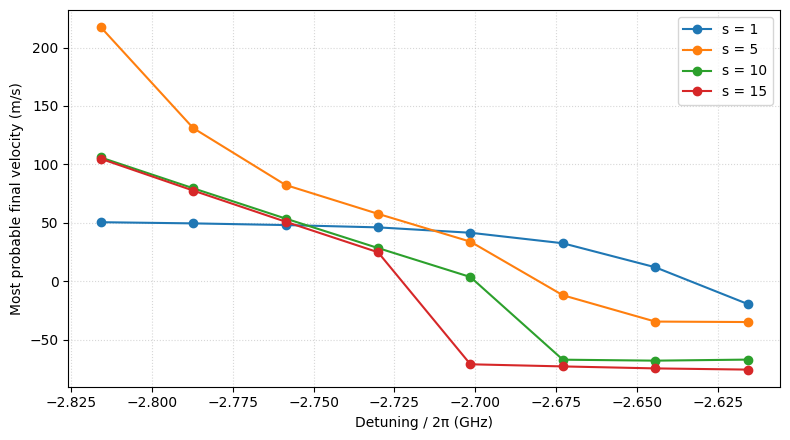

In [5]:
# Most probable final velocity vs detuning for several saturation parameters
advanced_state = globals().get("_advanced_state")
if not advanced_state:
    raise RuntimeError("Run the advanced Zeeman slower widget (Cell 9) before executing this analysis.")
if "plot_phase_space" not in globals():
    raise RuntimeError("Run the phase-space cell (Cell 12) once so helper functions are defined and cached.")

species_props = dict(advanced_state["species_props"])
sat_in = species_props.get("sat_intensity", 60.0) or 60.0
gamma = float(species_props["gamma"])
wavelength = float(species_props["wavelength"])
mass = float(species_props["mass"]) * amu
kk = 2 * math.pi / wavelength

params = advanced_state["params"]
g_eff_val = float(params["g_eff"])
v_capture = float(params["v0"])
v_final = float(params["vf"])
if v_capture <= v_final:
    raise RuntimeError("Stored profile has v0 <= vf. Rerun Cell 9 with valid parameters.")

z_axis_core = np.asarray(advanced_state["z"])
z_profile = np.asarray(advanced_state["z_extended"])
B_profile_extended = np.asarray(advanced_state["B_extended"])
if z_profile.size == 0 or B_profile_extended.size == 0:
    raise RuntimeError("Extended magnetic profile is empty. Re-run Cell 9.")

L_design = float(advanced_state["L"])
z_min, z_max = float(z_profile[0]), float(z_profile[-1])
flight_time = max(L_design / max(v_capture, 1.0), 1e-5)
base_dt = flight_time / max(len(z_axis_core) - 1, 1)
base_steps = max(len(z_profile), 2)
min_speed = 1e-4  # Prevent trajectories from stalling numerically.
sat_params = [1.0, 5.0, 10.0, 15.0]

ideal_detuning = float(diag["delta_ideal"])
ideal_detuning_ghz = ideal_detuning / (2 * math.pi * 1e9)
ghz_span = .2  # total span in GHz
num_detuning_points = 8
offsets_ghz = np.linspace(-ghz_span / 2.0, ghz_span / 2.0, num_detuning_points)
detuning_values_ghz = ideal_detuning_ghz + offsets_ghz

initial_velocities = np.linspace(max(1.0, v_final * 0.9), v_capture * 1.2, 10)

def scattering_force_vector(s_value, delta_laser, B_T, velocities):
    denom = 1.0 + s_value + (2.0 * (delta_laser + kk * velocities + g_eff_val * mu_B * B_T / hbar) / gamma) ** 2
    return hbar * kk * gamma / 2.0 * (s_value / denom)

def integrate_final_velocity(s_value, delta_laser, v_init):
    max_steps = int(math.ceil(base_steps * max(1.0, v_capture / max(abs(v_init), min_speed)) * 8.0))
    v_curr = v_init
    z_curr = z_min
    for _ in range(max_steps):
        if abs(v_curr) < min_speed:
            v_curr = np.copysign(min_speed, v_curr if abs(v_curr) > 1e-9 else 1.0)
        z_sample = float(np.clip(z_curr, z_min, z_max))
        B_val = np.interp(z_sample, z_profile, B_profile_extended)
        force = scattering_force_vector(s_value, delta_laser, B_val, v_curr)
        accel = -force / mass
        v_next = v_curr + accel * base_dt
        z_next = z_curr + v_curr * base_dt
        v_curr, z_curr = v_next, z_next
        if z_next >= z_max:
            break
    return v_curr

fig, ax = plt.subplots(figsize=(8, 4.5))
for s_value in sat_params:
    intensity_mw_cm2 = s_value * sat_in
    s_for_force = intensity_mw_cm2 / sat_in if sat_in else s_value
    mp_velocities = []
    for detuning_ghz in detuning_values_ghz:
        delta_laser = detuning_ghz * 1e9 * 2.0 * math.pi
        final_velocities = np.array([integrate_final_velocity(s_for_force, delta_laser, v0) for v0 in initial_velocities])
        if final_velocities.size == 0:
            mp_velocities.append(np.nan)
            continue
        hist, edges = np.histogram(final_velocities, bins=50)
        centers = 0.5 * (edges[:-1] + edges[1:])
        mp_velocity = centers[np.argmax(hist)] if np.any(hist) else np.nan
        mp_velocities.append(mp_velocity)
    ax.plot(detuning_values_ghz, mp_velocities, marker="o", label=f"s = {s_value:.0f}")

ax.set_xlabel("Detuning / 2π (GHz)")
ax.set_ylabel("Most probable final velocity (m/s)")
ax.grid(True, ls=":", alpha=0.5)
ax.legend(loc="best")
plt.tight_layout()
plt.show()